# Func SVD  

## Теория  

Представляем матрицу скоринга в виде произведения двух матриц: $R = P^T Q$. В отличие от простого SVD мы не делаем никаких предположений по поводу ортогональности или диагональсти этих матриц. Основная идея - представить исходную матрицу в виде двух матриц меньшего размера.  

Элемент скоринговой матрицы выражается счерез $P$ и $Q$ : $r_{ui} = \sum^f_k p^T_{uk} q_{ik}$, где f есть число до которого мы хотим "сжать" матрицы по одной из размерностей.
![How Func SVD works (arXiv:2203.11026v1)](./picts/Func_SVD.jpg)

Заметим, что получение матриц P и Q не требует заполнения всех ячеек исходной матрицы R, однако после восстановления R из перемножения P и Q мы получим числа во всехя ячейках, а значит предсказания скоринго для соответствующих объектов.  

## Математика, получение P и Q

Получение матриц P и Q в общем происходит по следующем алгоритму.  
- Выбираем функциюю потер
- Выбираем метод оптимизации
- Обучаем коэффициенты в матрица P и Q на тренировачных данных (разряженной матрице R)
- Перемножаме полученные P и Q, получая полностью заполненную матрицу R

В данном случае функцией потерь будет квадратичная ошибка  с решетчатой регуляризацией.  

$$ L(p,q) = \sum_{u,i : train} (r_{ui} - \sum_k^f P_{uk} Q{ik} - \mu - b_u - b_i)^2 + \lambda (b_i^2 + b_u^2 + ||P_u||^2 + ||Q_i||^2)))$$

Где:  
- $\mu$ - среднее значение скора на всем датасете (убираем смещение ошибки)
- $b_u$ - смещение от элемента (матрица Q)
- $b_i$ - смещение от пользователя (матрица P)

Методом оптимизации будем градиентный спуск:  

$$P_{uk} = P_{uk} + \alpha (q_{ik} * err_{ui} - \lambda \, p_{uk})$$
$$Q_{ik} = Q_{ik} + \alpha (p_{uk} * err_{ui} - \lambda \, q_{ik})$$
$$b_u = b_u + \alpha (err_{ui} - \lambda b_u) $$
$$b_i = b_i + \alpha (err_{ui} - \lambda b_i)$$

Где err - есть ошибка: $err_{ui} = R_{ui} - P_u^T Q_u - \mu - b_i b_u$  

## Гипперпараметры
В данной реализации присутствует 4 гипперпараметра:  
- $\alpha$ коэффициент обучения от градиентного спуска
- $\lambda$ коэффициент регуляризации
- Количество шагов в градиентном спуске
- Число f, по которому разбиваются матрицы

Подбор всех гипперпараметров кроме числа шагов подбирался по сетке и из разумных соображений. Оптимальное количество шагов, выбиралось после получения остальных гипперпараметров.

## Correct

In [1]:
def pivot(ratings):
    R_matrix = pd.DataFrame()
    R_matrix = ratings.pivot_table(index='userId', columns='movieId', values='rating')
    R_matrix.rename(columns = dict(zip(R_matrix.columns, ratings.movieId.unique())), inplace = True)
    return R_matrix


def RMSE(R_pred, r):
    rmse = 0
    #R_pred_np = R_pred.to_numpy()
    r_np = r.to_numpy()
    #display(r)
    #display(r_np)
    for i in r_np:
        #print(i)
        #print(R_pred.iloc[int(i[0])][int(i[1])])
        rmse += (i[2] - R_pred[int(i[1])][int(i[0])]) **2

    return (rmse/len(r_np))**0.5


def Func_SVD_train(train, n_users, m_movies, d, epoch=5, gamma=0.02, lmbda=0.03, mu=0 ):
    #mu = train['rating'].mean()
    pu = np.random.normal(0, 0.1, (n_users, d))
    qm = np.random.normal(0, 0.1, (m_movies, d))
    bu = np.zeros(n_users)
    bm = np.zeros(m_movies)

    movieId_to_index = dict(zip(train.movieId.unique(), range(m_movies)))

    #epoch = 5
    #gamma = 0.02
    #lmbda = 0.03

    for _ in range(epoch):
        
        for index in range(train.shape[0]):
    
            user_id = ratings['userId'][index] - 1
            movie_id = movieId_to_index[ratings['movieId'][index]]
            rating = ratings['rating'][index]
            #print(user_id, movie_id, rating, index)
    
            err = rating - (mu + bu[user_id] + bm[movie_id] + qm[movie_id] @ pu[user_id])
    
            bu[user_id] += gamma * (err - lmbda * bu[user_id]) 
            bm[movie_id] += gamma * (err - lmbda * bm[movie_id]) 
            pu_ = gamma * (err * qm[movie_id] - lmbda * pu[user_id])
            qm_ = qm[movie_id] + gamma * (err * pu[user_id] - lmbda * qm[movie_id])
            pu[user_id] = pu_
            qm[movie_id] = qm_

    return pu, qm, bu, bm


def Func_SVD_predict(pu, qm, bu, bm, mu,  n_users, m_movies):
    R_pred = np.zeros((n_users, m_movies))

    for user in range(n_users):
        for movie in range(m_movies):
            R_pred[user][movie] = round(mu + bu[user] + bm[movie] + qm[movie] @ pu[user], 2)

    R_pred = pd.DataFrame(R_pred, range(1,611), ratings.movieId.unique())
    R_pred.insert(0, "userId", ratings.userId.unique())
            
    return R_pred

In [2]:
import pandas as pd
from IPython.display import display
import numpy as np
from sklearn.utils import shuffle

ratings = pd.read_csv("./ml-latest-small/ratings.csv").loc[:,["userId", "movieId", "rating"]]
shuffle(ratings)

,userId,movieId,rating
48947,317,81932,2.0
48545,313,4148,2.0
91855,596,2723,3.5
38082,260,5782,3.5
6230,42,3441,4.0
...,...,...,...
81469,514,184987,3.0
50442,325,4954,2.0
47381,307,6058,2.0
4220,28,345,4.0


In [3]:
m, n = ratings.shape
train_m = int(m*0.9)
#test_m = m//2

train_r = ratings[:train_m]
test_r = ratings[train_m:]

#R_train = pivot(train_r)
#R_test = pivot(test_r)
R_matrix = pivot(ratings) 

In [52]:
n_users, m_movies = R_matrix.shape
mu = train_r['rating'].mean()

pu, qm, bu, bm = Func_SVD_train(train_r, n_users, m_movies, d=20, epoch=20, gamma=0.02, lmbda=0.035, mu=mu )

mu=test_r['rating'].mean()
R_pred = Func_SVD_predict(pu, qm, bu, bm, mu, n_users, m_movies)

print(R_pred.shape)
print(train_r.shape)
print(test_r.shape)

print("RMSE = ", RMSE(R_pred=R_pred, r=train_r))

print("RMSE = ", RMSE(R_pred=R_pred, r=test_r))      


(610, 9725)
(90752, 3)
(10084, 3)
RMSE =  0.8570271598467821
RMSE =  0.924691689347897


In [ ]:
#[1.001737309798396, {'d': 20, 'gamma': 0.01, 'lmbda': 0.01}]#

In [48]:
#Grid search:
params = {
    "d": [100],
    "gamma" : [0.005, 0.01, 0.01, 0.05],
    "lmbda" : [0.005, 0.01, 0.02, 0.05]
}

grid_info = []
score = 100000
best_params = None
n_users, m_movies = R_matrix.shape

for d_k in params["d"]:
    for gamma_k in params["gamma"]:
        for lmbda_k in params["lmbda"]:
            mu = train_r['rating'].mean()
            pu, qm, bu, bm = Func_SVD_train(train_r, n_users, m_movies, d=d_k, epoch=20, gamma=gamma_k, lmbda=lmbda_k, mu=mu)
            mu=test_r['rating'].mean()
            R_pred = Func_SVD_predict(pu, qm, bu, bm, mu, n_users, m_movies)
            
            rmse = RMSE(R_pred=R_pred, r=test_r)

            if score < rmse:
                score = rmse
                best_params = {"d": d_k, "gamma" : gamma_k, "lmbda" : lmbda_k }
            
            grid_info.append([rmse,{"d": d_k, "gamma" : gamma_k, "lmbda" : lmbda_k }])

            print("Passed" , grid_info[-1])

print("BEST params and score", best_params, score)
        

Passed [0.9385573793770848, {'d': 100, 'gamma': 0.005, 'lmbda': 0.005}]
Passed [0.9396699955386825, {'d': 100, 'gamma': 0.005, 'lmbda': 0.01}]
Passed [0.9369676883586585, {'d': 100, 'gamma': 0.005, 'lmbda': 0.02}]
Passed [0.9384562741548458, {'d': 100, 'gamma': 0.005, 'lmbda': 0.05}]
Passed [0.9303998715945065, {'d': 100, 'gamma': 0.01, 'lmbda': 0.005}]
Passed [0.9301428374909199, {'d': 100, 'gamma': 0.01, 'lmbda': 0.01}]
Passed [0.9288443917074307, {'d': 100, 'gamma': 0.01, 'lmbda': 0.02}]
Passed [0.9299952602319792, {'d': 100, 'gamma': 0.01, 'lmbda': 0.05}]
Passed [0.9302282906625169, {'d': 100, 'gamma': 0.01, 'lmbda': 0.005}]
Passed [0.931456491712839, {'d': 100, 'gamma': 0.01, 'lmbda': 0.01}]
Passed [0.9289051863885164, {'d': 100, 'gamma': 0.01, 'lmbda': 0.02}]
Passed [0.92938481186236, {'d': 100, 'gamma': 0.01, 'lmbda': 0.05}]
Passed [0.9370015295200381, {'d': 100, 'gamma': 0.05, 'lmbda': 0.005}]
Passed [0.9338077404225039, {'d': 100, 'gamma': 0.05, 'lmbda': 0.01}]
Passed [0.93390

In [10]:
print(grid_info)

NameError: name 'grid_info' is not defined

In [ ]:
# Делю дату на тест и тренировочную в соотношении 8 : 2
# optuna ???
# Учу на тренировочной 
# Проверяю на тестовой с ошибкой rmse
# Вывод топ n рекомендаций

In [40]:
from surprise import Reader, Dataset, SVD
from surprise.model_selection import train_test_split
from surprise import accuracy
n_users, m_movies = R_matrix.shape
# создание объекта класса Reader
reader = Reader(rating_scale=(1, 10))

# создание объекта класса Dataset
dataset = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

# разбиение данных на обучающую и тестовую выборки
trainset, testset = train_test_split(dataset, test_size = 0.1)

# создание экземпляра класса SVD
model = SVD()

# обучение модели на обучающей выборке
model.fit(trainset)

# предсказание рейтингов на тестовой выборке
predictions = model.test(testset)

# оценка качества модели
print('RMSE:', accuracy.rmse(model.test(trainset)))
print('RMSE:', accuracy.rmse(predictions))
print('MAE:', accuracy.mae(predictions))

R_pred_surprise = np.zeros((n_users, m_movies))
for u in range(n_users):
    for m in range(m_movies):
        R_pred_surprise[u][m] = model.predict(u, m).est
        
pd.DataFrame(np.round(R_pred_surprise, 2), range(1,n_users+1), ratings.movieId.unique())

TypeError: 'Trainset' object is not iterable

In [7]:
R_matrix

movieId,1,3,6,47,50,70,101,110,151,157,...,147662,148166,149011,152372,158721,160341,160527,160836,163937,163981
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,2.5,NaN,NaN,NaN,NaN,NaN,2.5,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,2.5,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
R_pred

,userId,1,3,6,47,50,70,101,110,151,...,147662,148166,149011,152372,158721,160341,160527,160836,163937,163981
1,1,4.58,3.85,4.24,4.51,4.83,3.85,4.46,4.20,4.42,...,3.85,3.95,3.97,3.90,4.12,3.99,3.89,3.93,3.88,3.73
2,2,3.87,3.09,3.69,3.73,3.99,3.35,3.66,3.74,3.54,...,3.23,3.30,3.27,3.39,3.35,3.44,3.28,3.35,3.26,3.25
3,3,2.61,2.02,2.64,2.99,3.46,2.55,2.25,2.78,2.83,...,2.33,2.01,2.65,2.11,1.94,2.29,2.10,2.15,2.28,2.25
4,4,3.45,2.69,3.76,2.47,3.78,2.74,3.44,3.29,2.70,...,3.00,3.09,2.64,3.54,3.27,2.86,3.08,3.31,2.88,3.11
5,5,3.71,2.93,3.84,3.86,3.99,3.23,3.61,3.69,3.24,...,3.30,3.10,3.16,3.29,3.34,3.19,3.13,3.34,3.22,3.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,606,3.85,3.07,4.01,3.84,4.09,3.15,3.68,3.82,3.38,...,3.49,3.40,3.25,3.27,3.44,3.17,3.37,3.40,3.30,3.52
607,607,3.63,3.09,3.74,3.34,4.03,3.38,3.47,3.84,3.42,...,3.28,3.36,3.17,3.40,3.15,3.43,3.38,3.25,3.26,3.26
608,608,3.83,3.06,3.89,3.58,4.47,3.21,3.42,3.97,3.45,...,3.35,3.28,3.27,3.47,3.49,3.42,3.28,3.24,3.36,3.30
609,609,3.59,3.18,3.85,3.69,4.03,3.40,3.48,4.05,3.42,...,3.07,3.26,3.26,3.20,3.16,3.41,3.42,3.04,3.39,3.20


In [4]:
rmse_epoch = {}
for epoch in range(1,50):
    n_users, m_movies = R_matrix.shape
    mu = train_r['rating'].mean()
    
    pu, qm, bu, bm = Func_SVD_train(train_r, n_users, m_movies, d=20, epoch=epoch, gamma=0.02, lmbda=0.035, mu=mu )
    
    mu=test_r['rating'].mean()
    R_pred = Func_SVD_predict(pu, qm, bu, bm, mu, n_users, m_movies)
    
    #print("RMSE = ", RMSE(R_pred=R_pred, r=train_r))
    rmse_epoch[epoch] = RMSE(R_pred=R_pred, r=test_r)
    print("RMSE = ", rmse_epoch[epoch]) 


    

RMSE =  0.9700494084424341
RMSE =  0.9531683007734616
RMSE =  0.9458259257771865
RMSE =  0.9395925727129508
RMSE =  0.9360684362875036
RMSE =  0.9333754848484036
RMSE =  0.930390689221176
RMSE =  0.9295061718581616
RMSE =  0.9284268138475782
RMSE =  0.9272619994097625
RMSE =  0.9263522711933634
RMSE =  0.9258686327493146
RMSE =  0.9256838011986965
RMSE =  0.925191372508191
RMSE =  0.9248255890119143
RMSE =  0.9250455942535174
RMSE =  0.9241394680706252
RMSE =  0.9247750082836672
RMSE =  0.9245116478386257
RMSE =  0.923958186641816
RMSE =  0.9249185883532254
RMSE =  0.9244727262063542
RMSE =  0.924782278696385
RMSE =  0.9250799197868593
RMSE =  0.9246338941221344
RMSE =  0.9251862811882002
RMSE =  0.925657468670694
RMSE =  0.9251764682597906
RMSE =  0.9253620655720884
RMSE =  0.9254067150494595
RMSE =  0.925831444457477
RMSE =  0.9259993690149614
RMSE =  0.926017199638421
RMSE =  0.9262992419304643
RMSE =  0.926168242838227
RMSE =  0.9271696308632438
RMSE =  0.9268030231461373
RMSE =  0

Text(25, 0.96, 'Minimum')

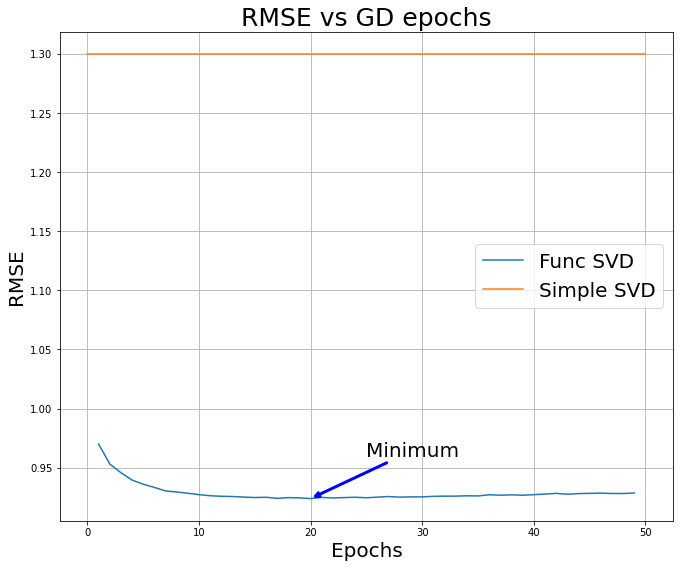

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplot_mosaic([['1']])

fig.set_figheight(9)
fig.set_figwidth(11)

rmse_epoch_pd = pd.DataFrame({"epoch" : rmse_epoch.keys(), "rmse" : rmse_epoch.values()})

ax['1'].plot(rmse_epoch.keys(), rmse_epoch.values(), label="Func SVD")
ax['1'].plot(np.array([0.0, 50]), np.array([1.3, 1.3]), label="Simple SVD")

ax['1'].set_xlabel("Epochs", fontsize=20)
ax['1'].set_ylabel("RMSE", fontsize=20)
ax['1'].grid(True)
ax['1'].set_title("RMSE vs GD epochs", fontsize=25)
ax['1'].legend(fontsize=20, loc=5)
ax['1'].annotate("Minimum",
                (20, 0.9240),
                xytext= (20+5, 0.95+0.01),
                arrowprops=dict(arrowstyle='->', color='blue', linewidth=3, mutation_scale=10),
                fontsize=20)